In [1]:
import os
import sys
from os.path import join as pjoin
from yaml import safe_load
import numpy as np
import importlib

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

## Exploratory Data Analysis

This is a visualization of the first batch of labeled FAST exams.

We define the relevant directories and transformations before loading a single image. It will be formatted as a PyTorch tensor with values in the interval \[-1,1\].

I am currently treating the data as if it had RGB values even though I suspect that it is really supposed to be BW. I'll leave it for now but check with the doctors to determine if this is every helpful or if it only introduces misleading information. 

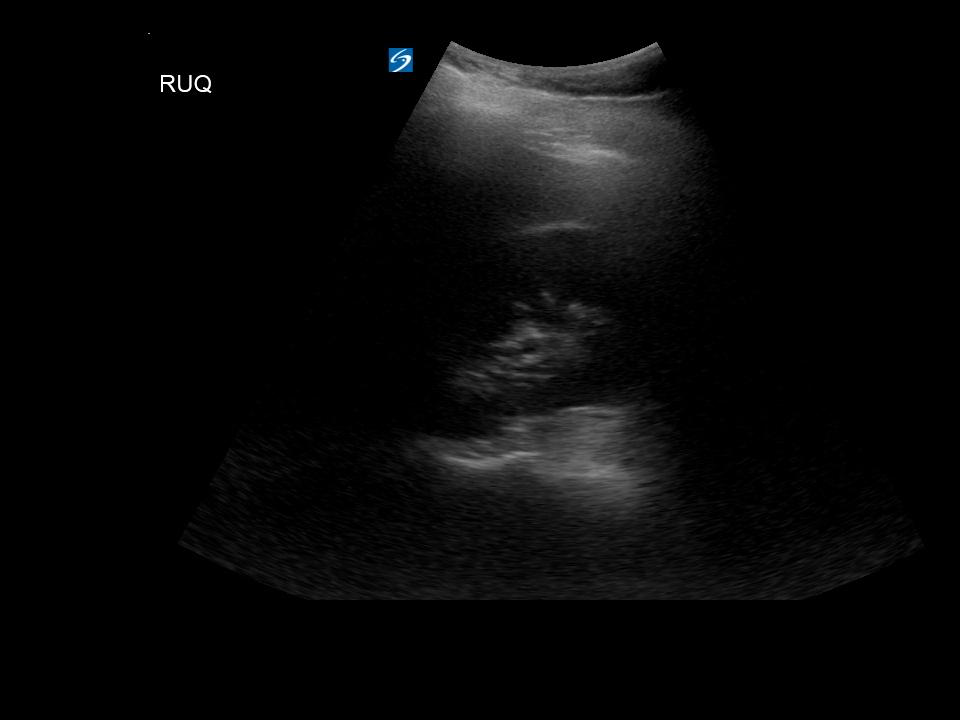

In [2]:
data_dir = '/scratch/users/austin.zane/ucsf_fast/data/pilot_labeling/AnnotationData/MorisonPouchMasks_1-23'
image_path = pjoin(data_dir, 'A_EL1N1D_77.png')
mask_path = pjoin(data_dir, 'A_EL1N1D_77_Morison.png')

PIL2Tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

PIL2TensorSmall = transforms.Compose([
    transforms.Resize((720,960)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

unnorm_transform = transforms.Compose([
    transforms.Normalize(mean=[-1.0], std=[2]),
    #transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2, 2, 2]),
])

image_raw = Image.open(image_path).convert('RGB')
image_raw

The next step is to plot the data to ensure that none of the information has been destroyed so far.

In [ ]:
image = PIL2Tensor(image_raw)
print(image.shape)

image_inv_np = unnorm_transform(image).numpy().transpose(1,2,0)
print(image_inv_np.shape)
plt.imshow(image_inv_np)
plt.axis('off')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Set titles for subplots
axes[0].set_title('Channel 1 Histogram')
axes[1].set_title('Channel 2 Histogram')
axes[2].set_title('Channel 3 Histogram')

# Calculate and plot the histogram for each channel
for i in range(image.shape[0]):
    # Flatten the channel to turn it into a 1D array for histogram calculation
    channel_data = image[i].flatten()
    
    # Check if there are varying values in the channel
    if torch.all(channel_data == channel_data[0]):
        # If the values don't vary, just display a message
        axes[i].text(0.5, 0.5, 'All values are ' + str(channel_data[0].item()),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axes[i].transAxes)
        axes[i].set_xlim([0, 1])
    else:
        # Plot histogram for channel with varying values
        axes[i].hist(channel_data.numpy(), bins=30, range=(-1.0, 1.0), color='blue', alpha=0.7)

# Show the figure with histograms
plt.tight_layout()
plt.show()

In [ ]:
mask_raw = Image.open(mask_path).convert('RGB')
mask_raw

In [ ]:
mask = PIL2Tensor(mask_raw)
print(mask.shape)

mask_inv_np = unnorm_transform(mask).numpy().transpose(1,2,0)
print(mask_inv_np.shape)
plt.imshow(mask_inv_np)
plt.axis('off')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Set titles for subplots
axes[0].set_title('Channel 1 Histogram')
axes[1].set_title('Channel 2 Histogram')
axes[2].set_title('Channel 3 Histogram')

# Calculate and plot the histogram for each channel
for i in range(mask.shape[0]):
    # Flatten the channel to turn it into a 1D array for histogram calculation
    channel_data = mask[i].flatten()
    
    # Check if there are varying values in the channel
    if torch.all(channel_data == channel_data[0]):
        # If the values don't vary, just display a message
        axes[i].text(0.5, 0.5, 'All values are ' + str(channel_data[0].item()),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axes[i].transAxes)
        axes[i].set_xlim([0, 1])
    else:
        # Plot histogram for channel with varying values
        axes[i].hist(channel_data.numpy(), bins=30, range=(-1.0, 1.0), color='blue', alpha=0.7)

# Show the figure with histograms
plt.tight_layout()
plt.show()

In [ ]:
mask.shape

In [ ]:
import os
os.getcwd()

# Loading all images in pilot labeling batch

We've loaded and looked at a single image+mask pair. Now we will load all of the images and produce some descriptive statistics.

In [4]:
img_files = [f for f in os.listdir(data_dir) if (not '_Morison' in f and not '.db' in f and not '.json' in f)]
img_array = []
label_array = []

for img_name in img_files:
    label_name = img_name.rsplit('.', 1)[0] + '_Morison.png'
    
    img_path = os.path.join(data_dir, img_name)
    label_path = os.path.join(data_dir, label_name)
    
    image = Image.open(img_path).convert('L')
    
    if not os.path.exists(label_path):
        print(f'For image {img_name}, the label {label_name} does not exist')
        continue
    label = Image.open(label_path).convert('L')
    
    img_array.append(image)
    label_array.append(label)
    
print(len(img_array))

384


These images either don't have annotations in the directory or the name of the annotation is different than expected. We will address this later.

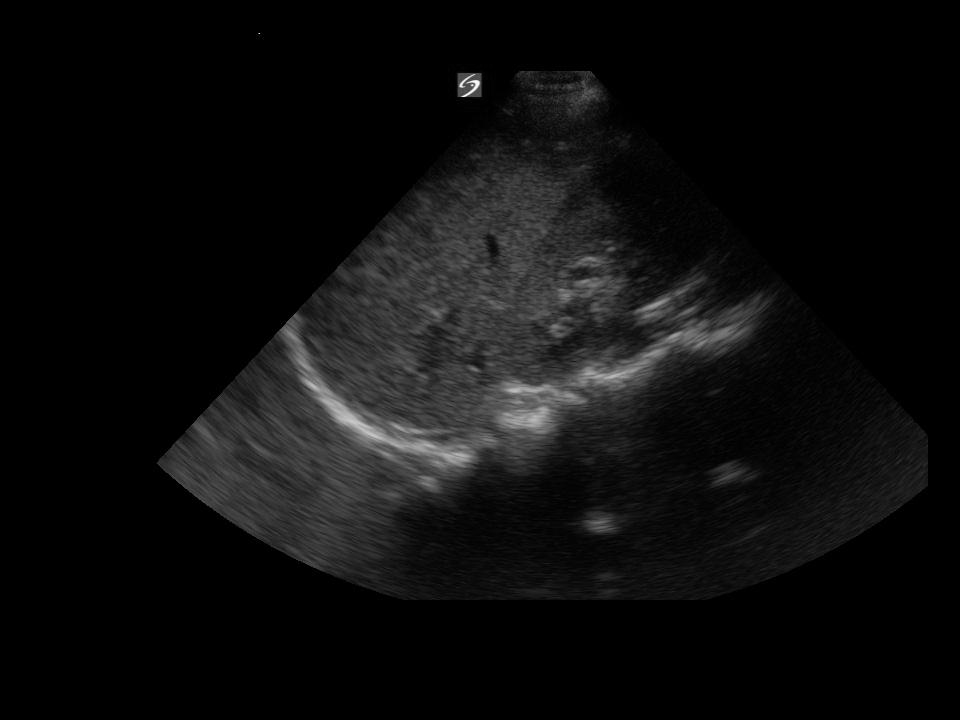

In [26]:
img_array[0]

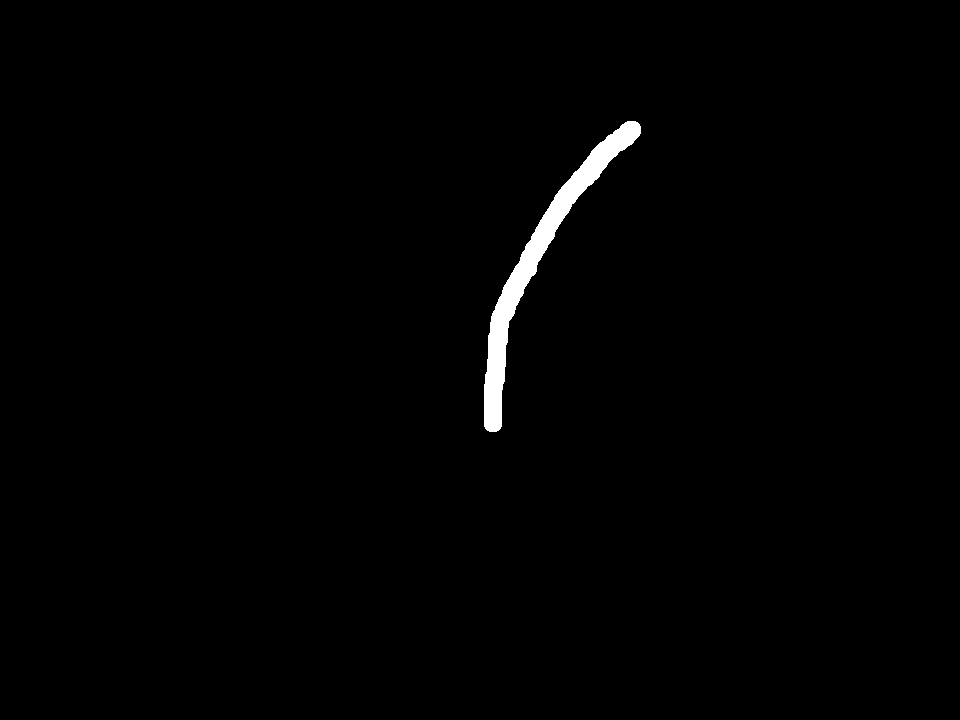

In [27]:
label_array[0]

In [48]:
img_tensor_array = img_array[:]
label_tensor_array = label_array[:]

heights, widths = [],[]
dims = []

for i in range(len(img_tensor_array)):
    img_tensor_array[i] = PIL2Tensor(img_tensor_array[i])
    heights.append(img_tensor_array[i].shape[1])
    widths.append(img_tensor_array[i].shape[2])
    dims.append(img_tensor_array[i].shape)
    
    label_tensor_array[i] = PIL2Tensor(label_tensor_array[i])

In [53]:
print(set(heights))
print(set(widths))
print(set(dims))
print(sum([h == 720 for h in heights]))

{720, 480}
{960, 640}
{torch.Size([1, 720, 960]), torch.Size([1, 480, 640])}
151


torch.Size([1, 720, 960])


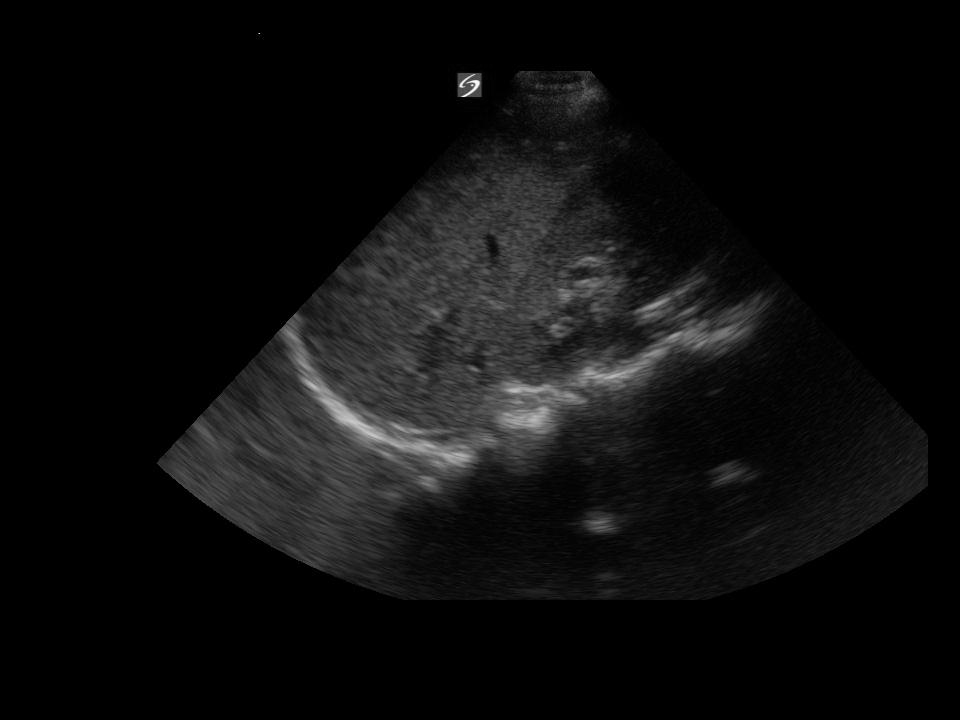

In [50]:
l = 0
print(img_tensor_array[l].shape)
img_array[l]

torch.Size([1, 720, 960])


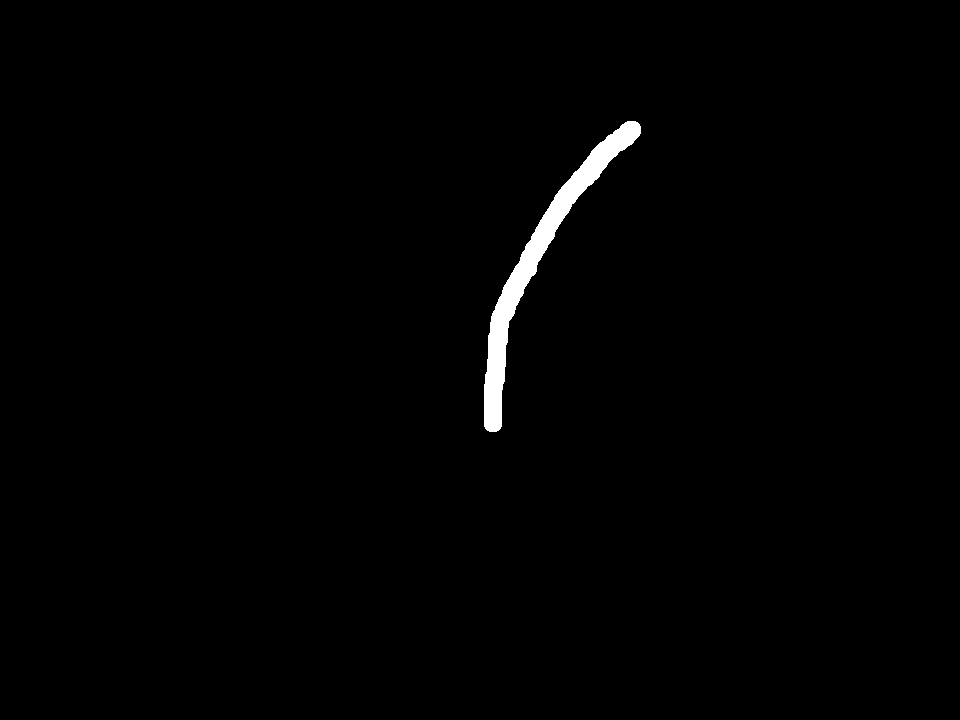

In [51]:
print(label_tensor_array[l].shape)
label_array[l]

In [58]:
img_array[2].__dict__

{'im': <ImagingCore at 0x7f7e5f6a5830>,
 'mode': 'L',
 '_size': (640, 480),
 'palette': None,
 'info': {'jfif': 257,
  'jfif_version': (1, 1),
  'jfif_unit': 0,
  'jfif_density': (1, 1)},
 '_category': 0,
 'readonly': 0,
 'pyaccess': None,
 '_exif': None}

## Resizing smaller images while loading all

In [72]:
img_tensor_array = img_array[:]
label_tensor_array = label_array[:]

heights, widths = [],[]
dims = []

for i in range(len(img_tensor_array)):
    if img_tensor_array[i]._size == (640, 480):
        img_tensor_array[i] = PIL2TensorSmall(img_tensor_array[i])
    elif img_tensor_array[i]._size == (960, 720):
        img_tensor_array[i] = PIL2Tensor(img_tensor_array[i])
    else:
        print('Error: unexpected image dimensions.')
        break
    
    heights.append(img_tensor_array[i].shape[1])
    widths.append(img_tensor_array[i].shape[2])
    dims.append(img_tensor_array[i].shape)
    
    label_tensor_array[i] = PIL2Tensor(label_tensor_array[i])

print(set(heights))
print(set(widths))
print(set(dims))

{720}
{960}
{torch.Size([1, 720, 960])}


(720, 960, 1)


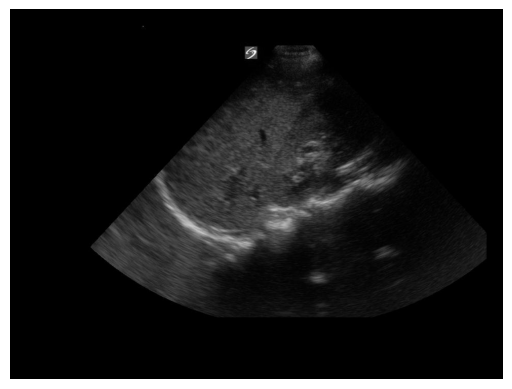

In [80]:
image_inv_np = unnorm_transform(img_tensor_array[0]).numpy().transpose(1,2,0)
print(image_inv_np.shape)
plt.imshow(image_inv_np.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [92]:
test_img = transforms.Resize((720, 960))(img_array[0])

In [93]:
test_img._size

(960, 720)

In [15]:
img_array[0]._size

NameError: name 'img_array' is not defined

## Checking if masks are nonbinary after scaling
We want the pixels in the mask images to be binary. Scaling requires interpolation that might introduce nonbinary values.

Observe that we do indeed introduce non-binary values with the default interpolation.

In [18]:
label_array[1].size
test_tensor_label = PIL2Tensor(label_array[1])
test_resized_label = PIL2TensorSmall(label_array[1])
print(test_tensor_label.shape)
print(test_resized_label.shape)
print(torch.unique(test_tensor_label))
print(torch.unique(test_resized_label))

torch.Size([1, 480, 640])
torch.Size([1, 720, 960])
tensor([-1.,  1.])
tensor([-1.0000, -0.9451, -0.8353, -0.8275, -0.7255, -0.7176, -0.6627, -0.4980,
        -0.3882, -0.1686, -0.1608,  0.0039,  0.1686,  0.3882,  0.5059,  0.6627,
         0.7176,  0.7255,  0.8353,  0.9451,  1.0000])


tensor([-1.,  1.])
tensor([-1.0000, -0.9451, -0.8353, -0.8275, -0.7255, -0.7176, -0.6627, -0.4980,
        -0.3882, -0.1686, -0.1608,  0.0039,  0.1686,  0.3882,  0.5059,  0.6627,
         0.7176,  0.7255,  0.8353,  0.9451,  1.0000])


# Testing Custom Dataset Class

I've created a dataset class in `~/ucsf_fast/common/datasets/__init__.py` that will load an image+mask pair and return it as part of a dataloader. I will test it now.

There are still issues caused by images with no labels. The main way to deal with this will be creating my own images from the raw data and stopping this from happening in the first place. 

I'll delete them for now...

In [3]:
sys.path.append('/accounts/campus/austin.zane/ucsf_fast')
from common.datasets import FASTDataset

In [4]:
custom_dataset = FASTDataset(data_dir=data_dir, transform=PIL2Tensor)

In [5]:
dataloader = DataLoader(custom_dataset, batch_size=len(custom_dataset), shuffle=True)

In [6]:

for images, labels in dataloader:
    print(images.shape, labels.shape)
    train_img = images
    train_label = labels

torch.Size([384, 1, 720, 960]) torch.Size([384, 1, 720, 960])


In [8]:
def check_binary(tens):
    return torch.all((tens == -1) | (tens == 1))

print(check_binary(train_label))
print(check_binary(train_img))

tensor(True)
tensor(False)
